In [34]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, StackedChebyshevKAN, StackedLegendreKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.problems import WaveEquation2D

subdomain_xs=[np.linspace(0,1,3), np.linspace(0,1,3)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 1.2),
        unnorm=(0.,5.),
    ),
    network=StackedChebyshevKAN,
    network_init_kwargs = dict(
        dims=[2, 4, 1],
        degrees=[5, 5]
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=30000,
    clear_output=False,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

# run = FBPINNTrainer(c)
# all_params = run.train()

In [36]:
# all_params_ = all_params
# all_params = all_params_[0]

In [137]:
import pickle
import numpy as np
import jax
import jax.numpy as jnp

def load_model(path):
    # 1) Un-pickle to get your pytree of numpy ndarrays (and other objects)
    with open(path, "rb") as f:
        model = pickle.load(f)

    # 2) Convert any numpy arrays back into JAX arrays
    model = jax.tree_map(
        lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x,
        model
    )
    return model

# usage
n, all_params, all_opt_states, active, u_test_losses = load_model("/vol/bitbucket/ss7921/FBPINNs/benchmarks/notebooks/results/models/test/model_00030000.jax")

In [86]:
# l1 = all_params['trainable']['network']['subdomain']['coeffs_list'][0][4]
# l2 = all_params['trainable']['network']['subdomain']['coeffs_list'][1][4]
# l1.shape, l2.shape

In [87]:
# points = RectangularDomainND.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=c.n_test)
# points.shape

In [209]:
import matplotlib.pyplot as plt

def plot_sch(data_list, noshow=False):
    # Example: generating some data of shape (2, 200, 200) (real and imaginary)
    data = data_list
    n_fields, Ny, Nx = data.shape
    y = np.arange(Ny)
    x = np.arange(Nx)
    X, Y = np.meshgrid(x, y)
    
    titles = ['wave']  # extend or truncate as needed

    # create one tall figure with n_fields rows
    fig = plt.figure(figsize=(8, 4 * n_fields))
    for i in range(n_fields):
        ax = fig.add_subplot(n_fields, 1, i+1, projection='3d')
        # 100 levels; use ax.contour3D (alias for Axes3D.contour)
        cont = ax.contour3D(X, Y, data[i], 100, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('value')
        ax.set_title(titles[i] if i < len(titles) else f'field {i}')
        
    if not noshow:
        plt.tight_layout()
        plt.show()

In [89]:
decomp = RectangularDecompositionND
from jax import vmap
import fbpinns.windows as windows

def norm_fn(params, x):
    xmin, xmax = params["static"]["decomposition"]["subdomain"]["params"][:2]
    mu, sd = (xmax+xmin)/2, (xmax-xmin)/2
    return (x-mu)/sd

def unnorm_fn(params, u):
    params = params["static"]["decomposition"]["subdomain"]["params"]
    mu, sd = params[5]
    return (u-mu)/sd

def net(params, x, model_i=4):
    layer1 = params['trainable']['network']['subdomain']['coeffs_list'][0][model_i]
    layer2 = params['trainable']['network']['subdomain']['coeffs_list'][1][model_i]

    o = x
    o = ChebyshevKAN.forward(coeffs=layer1, kind=2, x=o)
    o = ChebyshevKAN.forward(coeffs=layer2, kind=2, x=o)
    return o

def window(params, x):
    params = params["static"]["decomposition"]["subdomain"]["params"]
    a = params[4]*windows.cosine(*params[:2], x)+(1-params[4])
    return a

def foo(params, x, norm, network_fn, unnorm, window_fn):
    normed = norm(params, x)
    uraw = network_fn(params, normed)
    unnormed = unnorm(params, uraw)
    w = window_fn(params, x)
    return unnormed*w, w, uraw


In [90]:
# for i in range(9):
#     plot_sch(points_split_by_region[:, i, :].reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1))

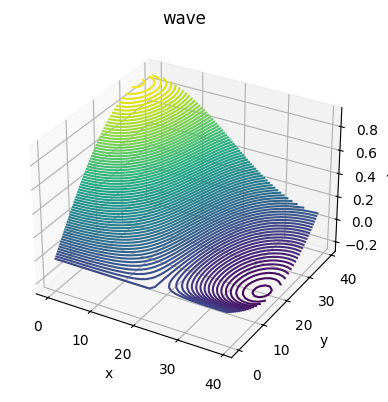

In [91]:
with open('/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave/CKAN_8/test_exact.npy', 'rb') as f:
    exact_wave = np.load(f).reshape(200, 200, -1)
plot_sch(exact_wave[:40, :40, :].transpose(2, 0, 1))

In [92]:
from fbpinns.trainers import get_inputs, _common_train_initialisation
from jax import random

(optimiser, all_opt_states, optimiser_fn, loss_fn, key,
        constraints_global, x_batch_global, constraint_offsets_global, constraint_fs_global, jmapss,
        x_batch_test, u_exact) = _common_train_initialisation(c, random.PRNGKey(c.seed), all_params, problem=WaveEquation2D, domain=RectangularDomainND)

active_test_ = jnp.ones(all_params["static"]["decomposition"]["m"], dtype=int)

takes_, all_ims_, (_, _, _, cut_all_, _)  = get_inputs(x_batch_test, active_test_, all_params, RectangularDecompositionND)

test_inputs = (takes_, all_ims_, cut_all_)

takes = takes_
m_take, n_take, p_take, np_take, npou = takes

[INFO] 2025-05-18 23:16:28 - Total number of trainable parameters:
[INFO] 2025-05-18 23:16:28 - 	attention: 40,000
[INFO] 2025-05-18 23:16:28 - 	network: 648
[INFO] 2025-05-18 23:16:28 - 	problem: 40,001
[INFO] 2025-05-18 23:16:28 - Total number of constraints: 1
[INFO] 2025-05-18 23:16:28 - Computing exact solution..
[INFO] 2025-05-18 23:16:28 - Computing done


In [93]:
all_params_cut = {"static":cut_all_(all_params["static"]),
                "trainable":cut_all_(all_params["trainable"])}

d = all_params_cut
all_params_take = {t_k: {cl_k: {k: jax.tree_map(lambda p:p[m_take], d[t_k][cl_k][k]) if k=="subdomain" else d[t_k][cl_k][k]
        for k in d[t_k][cl_k]}
        for cl_k in d[t_k]}
        for t_k in ["static", "trainable"]}
f = {t_k: {cl_k: {k: jax.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_map(lambda p: None, d[t_k][cl_k][k])
        for k in d[t_k][cl_k]}
        for cl_k in d[t_k]}
        for t_k in ["static", "trainable"]}

In [98]:
from functools import partial

x_take = x_batch_test[n_take]
us, ws, uraw = vmap(foo, in_axes=(f,0,None, None, None, None))(all_params_take, x_take, 
                                                               RectangularDecompositionND.norm_fn, 
                                                               StackedChebyshevKAN.network_fn, 
                                                               RectangularDecompositionND.unnorm_fn, 
                                                               window)
us.shape, ws.shape, uraw.shape

((57600, 1), (57600, 1), (57600, 1))

In [99]:
u = jnp.concatenate([us, ws], axis=1)
u = jax.ops.segment_sum(u, p_take, indices_are_sorted=False, num_segments=len(np_take))
wp = u[:,-1:]
u = u[:,:-1]/wp
u = jax.ops.segment_sum(u, np_take, indices_are_sorted=False, num_segments=len(x_batch_test))
u = u/npou
u = WaveEquation2D.constraining_fn(all_params, x_batch_test, u)

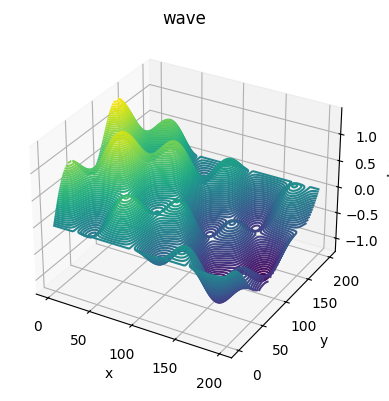

In [100]:
plot_sch(np.array(u).reshape(200, 200, 1).transpose(2, 0, 1))

In [ ]:
def models_infr(models, degrees=(0,6)):
    _, all_params, _, _, _ = load_model("/vol/bitbucket/ss7921/FBPINNs/benchmarks/notebooks/results/models/test/model_00030000.jax")

    a, b = all_params['trainable']['network']['subdomain']['coeffs_list']
    ka, kb = all_params['static']['network']['subdomain']['kinds']

    start_deg, end_deg = degrees

    c, d = a[models, :, :, start_deg:end_deg], b[models, :, :, start_deg:end_deg]
    kc, kd = ka[models, ], kb[models, ]
    print(a.shape, c.shape, kc, kd)

    changed_params = all_params.copy()
    changed_params['trainable']['network']['subdomain']['coeffs_list'] = (c, d)
    changed_params['static']['network']['subdomain']['kinds'] = (kc, kd)


    changed_params_cut = {"static":cut_all_(changed_params["static"]),
                    "trainable":cut_all_(changed_params["trainable"])}

    d = changed_params_cut
    changed_params_take = {t_k: {cl_k: {k: jax.tree_map(lambda p:p[m_take], d[t_k][cl_k][k]) if k=="subdomain" else d[t_k][cl_k][k]
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}
    f = {t_k: {cl_k: {k: jax.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_map(lambda p: None, d[t_k][cl_k][k])
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}

    us, ws, uraw = vmap(foo, in_axes=(f,0,None, None, None, None))(changed_params_take, x_take, 
                                                                RectangularDecompositionND.norm_fn, 
                                                                StackedChebyshevKAN.network_fn, 
                                                                RectangularDecompositionND.unnorm_fn, 
                                                                window)

    u = jnp.concatenate([us, ws], axis=1)
    u = jax.ops.segment_sum(u, p_take, indices_are_sorted=False, num_segments=len(np_take))
    wp = u[:,-1:]
    u = u[:,:-1]/wp
    u = jax.ops.segment_sum(u, np_take, indices_are_sorted=False, num_segments=len(x_batch_test))
    u = u/npou
    u = WaveEquation2D.constraining_fn(all_params, x_batch_test, u)
    return u

models_infr([0], degrees=(0, 1)).shape

(9, 2, 4, 6) (1, 2, 1, 1) [2] [2]


(40000, 1)

(9, 2, 4, 6) (1, 2, 1, 6) [2] [2]


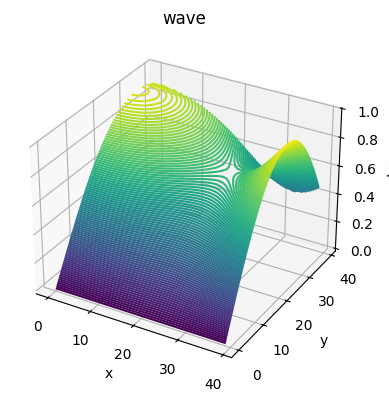

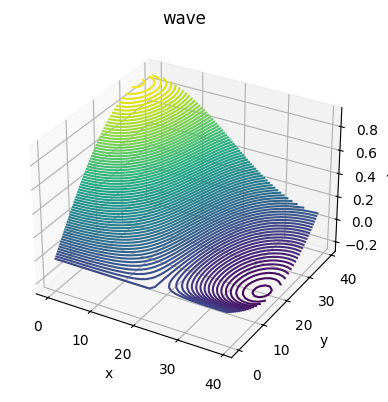

In [246]:
plot_sch(models_infr([0]).reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1))
plot_sch(exact_wave[:40, :40, :].transpose(2, 0, 1))

In [230]:
# for i in range(9):
#     models_infr([i])